## Overview

We implemented and validated a finite element method for 1D blood flow simulation:

| Method | Accuracy | Use Case |
|--------|----------|----------|
| **SEM** | Exact (analytical) | Reference/validation |
| **Shooting** | $O(10^{-12})$ | Reference/validation |
| **FEM** | $O(h^2)$ | Practical simulations |

**Key Results:**
- FEM achieves $O(h^2)$ convergence as expected for linear elements
- All three methods agree to within numerical precision
- Time-domain simulations correctly reproduce physiological waveforms

## Derivation of the Frequency-Domain Governing Equations -- Summarized 

### Starting Point: 1D Blood Flow Equations (Lee & Jang 2012)

The one-dimensional blood flow model is derived from conservation laws applied to a compliant arterial segment. The two fundamental equations are:

**1. Conservation of Mass (Continuity):**
$$\frac{\partial A}{\partial t} + \frac{\partial Q}{\partial x} = 0$$

**2. Conservation of Momentum:**
$$\frac{\partial Q}{\partial t} + \frac{\partial}{\partial x}\left(\gamma \frac{Q^2}{A}\right) + \frac{A}{\rho}\frac{\partial p}{\partial x} = -\frac{\alpha Q}{A} + \nu \frac{\partial^2 Q}{\partial x^2}$$

where:
- $A(x,t)$ = cross-sectional area
- $Q(x,t)$ = volumetric flow rate  
- $p(x,t)$ = transmural pressure
- $\gamma$ = momentum correction factor (= 1/3 for Poiseuille flow)
- $\alpha$ = viscous damping coefficient
- $\nu$ = kinematic viscosity

**3. Constitutive (Tube) Law:**
$$p - p_{ext} = \kappa\left(\sqrt{A} - \sqrt{A_0}\right)$$

which linearizes to:
$$p \approx \kappa \frac{A - A_0}{A_0} \quad \Rightarrow \quad A = A_0\left(1 + \frac{p}{\kappa}\right)$$


### Linearization Around Steady State

We linearize about the steady-state solution $(A_0, Q_d, p_0)$:
$$A = A_0 + \tilde{A}, \quad Q = Q_d + \tilde{Q}, \quad p = p_0 + \tilde{p}$$

where tildes denote small perturbations. Substituting and neglecting higher-order terms:

**Linearized Continuity:**
$$\frac{1}{\kappa}\frac{\partial p}{\partial t} + \frac{\partial q}{\partial x} = 0$$

(using $\tilde{A} = A_0 p/\kappa$ from the linearized tube law, and dropping tildes for clarity)

**Linearized Momentum:**
$$\frac{\partial q}{\partial t} + c_2 \frac{\partial p}{\partial x} + u\frac{\partial q}{\partial x} + \alpha q = \nu \frac{\partial^2 q}{\partial x^2}$$

where the derived coefficients are:
$$c_2 = \frac{A_0}{\rho} - \frac{\gamma Q_d^2}{\kappa A_0^2}, \quad u = \frac{2\gamma Q_d}{A_0}, \quad \alpha = \frac{2\gamma\theta Q_d}{A_0}$$


### Matrix Form in Time Domain

We write the system in matrix form with $\mathbf{u} = [p, q]^T$:

$$\mathbf{M}\frac{\partial^2 \mathbf{u}}{\partial t^2} + \mathbf{C}\frac{\partial \mathbf{u}}{\partial t} + \mathbf{G}\frac{\partial^2 \mathbf{u}}{\partial x \partial t} + \mathbf{D}\frac{\partial^2 \mathbf{u}}{\partial x^2} + \mathbf{A}\frac{\partial \mathbf{u}}{\partial x} + \mathbf{K}\mathbf{u} = \mathbf{0}$$

Matching terms from the linearized equations:

| Matrix | Expression | From Equation |
|--------|------------|---------------|
| $\mathbf{M}$ | $\begin{bmatrix} 0 & 0 \\ 0 & 0 \end{bmatrix}$ | No $\partial^2/\partial t^2$ terms |
| $\mathbf{C}$ | $\begin{bmatrix} 1/\kappa & 0 \\ 0 & 1 \end{bmatrix}$ | $\frac{1}{\kappa}\frac{\partial p}{\partial t}$ and $\frac{\partial q}{\partial t}$ |
| $\mathbf{G}$ | $\begin{bmatrix} 0 & 0 \\ 0 & 0 \end{bmatrix}$ | No mixed $\partial^2/\partial x\partial t$ terms |
| $\mathbf{D}$ | $\begin{bmatrix} 0 & 0 \\ 0 & -\nu \end{bmatrix}$ | $\nu\frac{\partial^2 q}{\partial x^2}$ (note: moved to LHS) |
| $\mathbf{A}$ | $\begin{bmatrix} 0 & 1 \\ c_2 & u \end{bmatrix}$ | $\frac{\partial q}{\partial x}$, $c_2\frac{\partial p}{\partial x}$, $u\frac{\partial q}{\partial x}$ |
| $\mathbf{K}$ | $\begin{bmatrix} 0 & 0 \\ 0 & \alpha \end{bmatrix}$ | $\alpha q$ |


### Fourier Transform to Frequency Domain

For periodic solutions, we apply the Fourier transform in time:
$$\mathbf{u}(x,t) = \hat{\mathbf{u}}(x,\omega)e^{i\omega t}$$

The differential operators transform as:
$$\frac{\partial}{\partial t} \rightarrow i\omega, \quad \frac{\partial^2}{\partial t^2} \rightarrow -\omega^2$$

Substituting into the matrix equation:
$$-\omega^2\mathbf{M}\hat{\mathbf{u}} + i\omega\mathbf{C}\hat{\mathbf{u}} + i\omega\mathbf{G}\hat{\mathbf{u}}' + \mathbf{D}\hat{\mathbf{u}}'' + \mathbf{A}\hat{\mathbf{u}}' + \mathbf{K}\hat{\mathbf{u}} = \mathbf{0}$$

Rearranging by order of spatial derivative:
$$\mathbf{D}\hat{\mathbf{u}}'' + \underbrace{(i\omega\mathbf{G} + \mathbf{A})}_{\mathbf{H}}\hat{\mathbf{u}}' + \underbrace{(i\omega\mathbf{C} + \mathbf{K} - \omega^2\mathbf{M})}_{\mathbf{L}}\hat{\mathbf{u}} = \mathbf{0}$$


### Final Form

$$\boxed{\mathbf{D}\hat{\mathbf{u}}'' + \mathbf{H}\hat{\mathbf{u}}' + \mathbf{L}\hat{\mathbf{u}} = \mathbf{0}}$$

where:
$$\mathbf{H}(\omega) = i\omega\mathbf{G} + \mathbf{A}, \qquad \mathbf{L}(\omega) = i\omega\mathbf{C} + \mathbf{K} - \omega^2\mathbf{M}$$

This is a **second-order ODE in space** with **frequency-dependent coefficients**. It is solved independently at each frequency $\omega$, then the time-domain solution is reconstructed via inverse FFT.

**Boundary Conditions:**
- Inlet ($x=0$): Prescribed flow $\hat{q}(0,\omega) = \hat{q}_{in}(\omega)$
- Outlet ($x=L$): Prescribed pressure $\hat{p}(L,\omega) = \hat{p}_{out}(\omega)$

This formulation is solved by all three methods (SEM, Shooting, FEM) implemented in this notebook.

In [1]:
import numpy
from numpy.linalg import solve, norm
from scipy.integrate import solve_ivp
from scipy.optimize import root_scalar
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import time

In [3]:
# prof lazar std
plt.rcParams.update({
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 14,
    'legend.fontsize': 11,
    'figure.figsize': (12, 8),
    'lines.linewidth': 2,
    'lines.markersize': 6,
})

In [5]:
#SAME AS EVA -- DELETE WHEN MERGING 
def make_sem_params(L, rho, A0, Qd, gamma, theta, nu, kappa):
    """Create parameter dictionary for blood flow simulation."""
    params = {
        'L': L, 'rho': rho, 'A0': A0, 'Qd': Qd,
        'gamma': gamma, 'theta': theta, 'nu': nu, 'kappa': kappa
    }
    params['c1'] = A0 / rho
    params['u'] = 2. * gamma * Qd / A0
    params['alpha'] = 2. * gamma * theta * Qd / A0
    params['c2'] = params['c1'] - gamma * Qd**2 / (kappa * A0**2)
    params['Qp'] = 26e-6
    params['Pd'] = 84.2
    params['Ps'] = 130.0
    return params

# Physical parameters
R = 0.0086
h = 0.000602
A0 = numpy.pi * R**2
L = 0.04
rho = 1055.0
nu = 4.6e-6
gamma = 1. / 3.
theta = 0.
Qd = 14e-6
E = 1.4812e6
mu = 0.25
kappa = 0.5 * E * h / (R * A0 * (1.0 - mu**2))

params = make_sem_params(L, rho, A0, Qd, gamma, theta, nu, kappa)

In [7]:
# Matrix Construction

# SAME AS EVA -- DELETE WHEN MERGING 
def make_sem_matrices(params):
    """Build coefficient matrices M, C, G, D, A, K from Lee & Jang."""
    A0 = params['A0']
    rho = params['rho']
    Qd = params['Qd']
    gamma = params['gamma']
    theta = params['theta']
    nu = params['nu']
    kappa = params['kappa']
    
    c1 = A0 / rho
    c2 = c1 - gamma * Qd**2 / (kappa * A0**2)
    u = 2. * gamma * Qd / A0
    alpha = 2. * gamma * theta * Qd / A0
    
    M = numpy.zeros((2, 2), dtype=complex)
    G = numpy.zeros((2, 2), dtype=complex)
    C = numpy.array([[1. / kappa, 0.], [0., 1.]], dtype=complex)
    D = numpy.array([[0., 0.], [0., -nu]], dtype=complex)
    A = numpy.array([[0., 1.], [c2, u]], dtype=complex)
    K = numpy.array([[0., 0.], [0., alpha]], dtype=complex)
    
    return M, C, G, D, A, K

# ADD!!! WHEN MERGING
def make_freq_matrices(omega, M, C, G, D, A, K):
    """Build frequency-domain matrices H and L."""
    H = 1j * omega * G + A
    L = 1j * omega * C + K - (omega**2) * M
    return D, H, L


## Shooting Method

The shooting method converts the boundary value problem (BVP) into initial value problems (IVPs). We reformulate the second-order system as a first-order system:
$$\frac{d}{dx}\begin{bmatrix} p \\ q \end{bmatrix} = \begin{bmatrix} a_{11} & a_{12} \\ a_{21} & a_{22} \end{bmatrix} \begin{bmatrix} p \\ q \end{bmatrix}$$

where the coefficients $a_{ij}$ are derived from the governing equations.

**Algorithm:**
1. Solve the homogeneous IVP with $p(0)=1, q(0)=0$
2. Solve the particular IVP with $p(0)=0, q(0)=q_{in}$
3. Use superposition to satisfy the outlet boundary condition $p(L) = p_{out}$

The shooting method provides a highly accurate reference solution (tolerance $10^{-12}$) for validating the FEM implementation.

In [9]:
# shooting method
def solve_time_domain_shooting(params, N_x=100, N_time=1000, T_period=1.0, t_snapshot=0.1):
    """
    Time-domain Shooting that also returns spatial solution at t_snapshot
    """
    from scipy.integrate import solve_ivp
    from scipy.interpolate import interp1d
    from scipy.optimize import brentq
    
    L_vessel = params['L']
    kappa = params['kappa']
    nu = params['nu']
    c2 = params['c2']
    u_vel = params['u']
    alpha = params['alpha']
    
    t = numpy.linspace(0.0, T_period, N_time)
    dt = t[1] - t[0]
    x_grid = numpy.linspace(0, L_vessel, N_x)
    dx = x_grid[1] - x_grid[0]
    
    q_in_t = inlet_flow(t, params)
    p_out_t = outlet_pressure(t, params)
    
    C_mat = numpy.array([[1./kappa, 0.], [0., 1.]])
    A_mat = numpy.array([[0., 1.], [c2, u_vel]])
    K_mat = numpy.array([[0., 0.], [0., alpha]])
    K_eff = K_mat + C_mat / dt
    
    p_in_t = numpy.zeros(N_time)
    q_out_t = numpy.zeros(N_time)
    
    p_old = numpy.ones(N_x) * p_out_t[0]
    q_old = numpy.ones(N_x) * q_in_t[0]
    
    p_in_t[0] = p_out_t[0]
    q_out_t[0] = q_in_t[0]
    
    beta = 1.0 / (kappa * dt)
    gamma = 1.0 / dt + alpha
    denom = c2 + nu * beta
    
    # Storage for spatial snapshot
    idx_snapshot = numpy.argmin(numpy.abs(t - t_snapshot))
    p_snapshot = None
    q_snapshot = None
    
    for n in range(1, N_time):
        q_in = q_in_t[n]
        p_out = p_out_t[n]
        
        p_old_interp = interp1d(x_grid, p_old, kind='linear', fill_value='extrapolate')
        q_old_interp = interp1d(x_grid, q_old, kind='linear', fill_value='extrapolate')
        p_old_x = numpy.gradient(p_old, dx)
        p_old_x_interp = interp1d(x_grid, p_old_x, kind='linear', fill_value='extrapolate')
        
        def ode_system(x, y):
            p, q = y
            p_old_val = p_old_interp(x)
            q_old_val = q_old_interp(x)
            p_old_x_val = p_old_x_interp(x)
            
            dq_dx = beta * (p_old_val - p)
            dp_dx = (q_old_val / dt - gamma * q + u_vel * beta * (p - p_old_val) + nu * beta * p_old_x_val) / denom
            
            return [dp_dx, dq_dx]
        
        def shooting_residual(p0):
            y0 = [p0, q_in]
            sol = solve_ivp(ode_system, [0, L_vessel], y0, method='RK45',
                           dense_output=True, rtol=1e-10, atol=1e-12)
            if not sol.success:
                return 1e10
            return sol.sol(L_vessel)[0] - p_out
        
        p_low, p_high = p_out * 0.5, p_out * 1.5
        res_low, res_high = shooting_residual(p_low), shooting_residual(p_high)
        
        for _ in range(10):
            if res_low * res_high < 0:
                break
            p_low *= 0.8
            p_high *= 1.2
            res_low, res_high = shooting_residual(p_low), shooting_residual(p_high)
        
        try:
            if res_low * res_high < 0:
                p0_solution = brentq(shooting_residual, p_low, p_high, xtol=1e-10)
            else:
                p0_solution = p_in_t[n-1]
        except:
            p0_solution = p_in_t[n-1]
        
        y0 = [p0_solution, q_in]
        sol = solve_ivp(ode_system, [0, L_vessel], y0, method='RK45',
                       dense_output=True, rtol=1e-10, atol=1e-12)
        
        y_at_x = sol.sol(x_grid)
        p_new = y_at_x[0, :]
        q_new = y_at_x[1, :]
        
        p_in_t[n] = p_new[0]
        q_out_t[n] = q_new[-1]
        
        # Save snapshot
        if n == idx_snapshot:
            p_snapshot = p_new.copy()
            q_snapshot = q_new.copy()
        
        p_old = p_new.copy()
        q_old = q_new.copy()
        
        if n % 200 == 0:
            print(f"  Shooting: step {n}/{N_time}")
    
    return t, x_grid, q_in_t, p_in_t, p_out_t, q_out_t, p_snapshot, q_snapshot

## Finite Element Method (FEM)

We discretize the weak form of the governing equations using linear Lagrange elements. The domain $[0, L]$ is divided into $N$ elements with $N+1$ nodes.

**Element Matrices:**
For each element of length $h$, we compute:
- Stiffness matrix: $K^e_{ab} = \frac{1}{h}\begin{bmatrix} 1 & -1 \\ -1 & 1 \end{bmatrix}$
- Advection matrix: $A^e_{ab} = \frac{1}{2}\begin{bmatrix} -1 & 1 \\ -1 & 1 \end{bmatrix}$
- Mass matrix: $M^e_{ab} = \frac{h}{6}\begin{bmatrix} 2 & 1 \\ 1 & 2 \end{bmatrix}$

**Assembly:**
The global system combines contributions from each element:
$$\mathbf{K}_{global}\mathbf{u} = \mathbf{f}$$

where the element block contribution is:
$$\mathbf{K}^e_{block} = -k_{ab}\mathbf{D} + a_{ab}\mathbf{H} + m_{ab}\mathbf{L}$$

**Boundary Conditions:**
- Inlet: $q(0) = q_{in}$ (prescribed flow)
- Outlet: $p(L) = p_{out}$ (prescribed pressure)

Linear elements yield $O(h^2)$ convergence for both pressure and flow rate.

In [11]:
# TIME-DOMAIN FEM
def fem_time_domain(params, N_elem=40, N_time=1000, T_period=1.0, return_spatial=False):
    """
    TIME-DOMAIN FEM using Backward Euler time integration.
    - Discretize space → system of ODEs in time
    - Time-step through the problem
    Solves: C ∂u/∂t + D ∂²u/∂x² + A ∂u/∂x + K u = 0
    """
    L_vessel = params['L']
    kappa = params['kappa']
    nu = params['nu']
    c2 = params['c2']
    u_vel = params['u']
    alpha = params['alpha']
    
    # Spatial discretization
    h_elem = L_vessel / N_elem
    x_nodes = numpy.linspace(0, L_vessel, N_elem + 1)
    n_nodes = N_elem + 1
    n_dof = 2 * n_nodes
    
    # Time discretization
    t = numpy.linspace(0.0, T_period, N_time)
    dt = t[1] - t[0]
    
    # Boundary conditions (directly in time domain)
    q_in_t = inlet_flow(t, params)
    p_out_t = outlet_pressure(t, params)
    
    # Element matrices
    K_elem = (1.0 / h_elem) * numpy.array([[1., -1.], [-1., 1.]])
    A_elem = 0.5 * numpy.array([[-1., 1.], [-1., 1.]])
    M_elem = (h_elem / 6.0) * numpy.array([[2., 1.], [1., 2.]])
    
    # PDE coefficient matrices (REAL, not complex)
    C_mat = numpy.array([[1./kappa, 0.], [0., 1.]])
    D_mat = numpy.array([[0., 0.], [0., -nu]])
    A_mat = numpy.array([[0., 1.], [c2, u_vel]])
    K_mat = numpy.array([[0., 0.], [0., alpha]])
    
    # Assemble global matrices
    M_global = numpy.zeros((n_dof, n_dof))
    K_global = numpy.zeros((n_dof, n_dof))
    
    for e in range(N_elem):
        node_i, node_j = e, e + 1
        local_dofs = [2*node_i, 2*node_i+1, 2*node_j, 2*node_j+1]
        
        M_e = numpy.zeros((4, 4))
        K_e = numpy.zeros((4, 4))
        
        for a in range(2):
            for b in range(2):
                kab, aab, mab = K_elem[a,b], A_elem[a,b], M_elem[a,b]
                M_e[2*a:2*a+2, 2*b:2*b+2] += mab * C_mat
                K_e[2*a:2*a+2, 2*b:2*b+2] += -kab * D_mat + aab * A_mat + mab * K_mat
        
        for ii in range(4):
            for jj in range(4):
                M_global[local_dofs[ii], local_dofs[jj]] += M_e[ii, jj]
                K_global[local_dofs[ii], local_dofs[jj]] += K_e[ii, jj]
    
    # Initialize
    U = numpy.zeros((N_time, n_dof))
    for i in range(n_nodes):
        U[0, 2*i] = p_out_t[0]
        U[0, 2*i+1] = q_in_t[0]
    
    # Time-stepping: Backward Euler (implicit, stable)
    A_system = M_global / dt + K_global
    
    for n in range(N_time - 1):
        rhs = (M_global / dt) @ U[n, :]
        A_bc = A_system.copy()
        
        # BC: q(0) = q_in
        A_bc[1, :] = 0
        A_bc[1, 1] = 1
        rhs[1] = q_in_t[n+1]
        
        # BC: p(L) = p_out
        A_bc[2*N_elem, :] = 0
        A_bc[2*N_elem, 2*N_elem] = 1
        rhs[2*N_elem] = p_out_t[n+1]
        
        U[n+1, :] = numpy.linalg.solve(A_bc, rhs)
    
    p_in_t = U[:, 0]
    q_out_t = U[:, 2*N_elem+1]
    
    if return_spatial:
        p_all = numpy.array([U[:, 2*i] for i in range(n_nodes)]).T
        q_all = numpy.array([U[:, 2*i+1] for i in range(n_nodes)]).T
        return t, x_nodes, q_in_t, p_in_t, p_out_t, q_out_t, p_all, q_all
    
    return t, q_in_t, p_in_t, p_out_t, q_out_t

## Physiological Boundary Conditions

We prescribe realistic cardiac waveforms as boundary conditions:

**Inlet Flow** $q(0,t)$: A pulsatile waveform constructed from Gaussian pulses representing systolic ejection:
$$q(0,t) = Q_d + (Q_p - Q_d) \cdot \text{shape}(t)$$
where $Q_d = 14$ mL/s (diastolic) and $Q_p = 26$ mL/s (peak systolic).

**Outlet Pressure** $p(L,t)$: A pressure waveform with systolic peak and dicrotic notch:
$$p(L,t) = P_d + (P_s - P_d) \cdot \text{shape}(t)$$
where $P_d = 84.2$ mmHg (diastolic) and $P_s = 130$ mmHg (systolic).

Both waveforms have period $T = 1$ s (60 bpm heart rate).

In [13]:
# Waveform Functions
# Generate physiological boundary conditions mimicking a cardiac cycle (period T = 1 s)

def inlet_flow(t, params):
    """
    Physiologic inlet flow waveform q(0,t).
    
    Constructs a pulsatile flow using sum of Gaussians to represent:
    - Systolic ejection peak
    - Secondary flow features
    
    Returns flow rate in m^3/s.
    """
    Qd, Qp = params['Qd'], params['Qp']  # Diastolic and peak systolic flow
    tau = (t % 1.0)  # Normalize to cardiac cycle (period = 1 s)
    
    # Sum of Gaussians to create realistic waveform shape
    f1 = numpy.exp(-((tau - 0.08) / 0.03)**2) * 1.0   # Primary systolic peak
    f2 = numpy.exp(-((tau - 0.20) / 0.07)**2) * 0.4   # Secondary peak
    f3 = numpy.exp(-((tau - 0.40) / 0.15)**2) * 0.2   # Diastolic tail
    shape = f1 + f2 + f3
    shape = shape / numpy.max(shape)  # Normalize to [0, 1]
    
    # Scale between diastolic (Qd) and peak (Qp) flow rates
    return Qd + (Qp - Qd) * shape


def outlet_pressure(t, params):
    """
    Physiologic outlet pressure waveform p(L,t).
    
    Constructs arterial pressure waveform with:
    - Systolic peak
    - Dicrotic notch (aortic valve closure)
    - Diastolic decay
    
    Returns pressure in Pa (converted from mmHg).
    """
    Pd = params['Pd'] * 133.322  # Diastolic pressure: mmHg → Pa
    Ps = params['Ps'] * 133.322  # Systolic pressure: mmHg → Pa
    tau = (t % 1.0)  # Normalize to cardiac cycle
    
    # Sum of Gaussians to create realistic pressure waveform
    p1 = numpy.exp(-((tau - 0.10) / 0.04)**2) * 1.0        # Systolic peak
    p2 = 0.35 * numpy.exp(-((tau - 0.22) / 0.08)**2)       # Dicrotic notch region
    p3 = 0.15 * numpy.exp(-((tau - 0.45) / 0.20)**2)       # Diastolic phase
    shape = p1 + p2 + p3
    shape = shape / numpy.max(shape)  # Normalize to [0, 1]
    
    # Scale between diastolic (Pd) and systolic (Ps) pressures
    return Pd + (Ps - Pd) * shape

## Validation 1: Spatial Distribution

We validate the FEM implementation by comparing the spatial distribution of pressure $|p(x)|$ and flow rate $|q(x)|$ against the shooting method (exact reference) at a test frequency of $f = 5$ Hz.

This plot demonstrates:
- FEM converges to the exact solution as mesh is refined ($N = 10, 20, 40$)
- All methods solve the same underlying physics
- FEM accurately captures the spatial variation along the vessel

Computing TD-Shooting reference solution...
  Shooting: step 200/1000
  Shooting: step 400/1000
  Shooting: step 600/1000
  Shooting: step 800/1000
Computing TD-FEM reference (N=80)...
Computing TD-FEM with N=10...
Computing TD-FEM with N=20...
Computing TD-FEM with N=40...


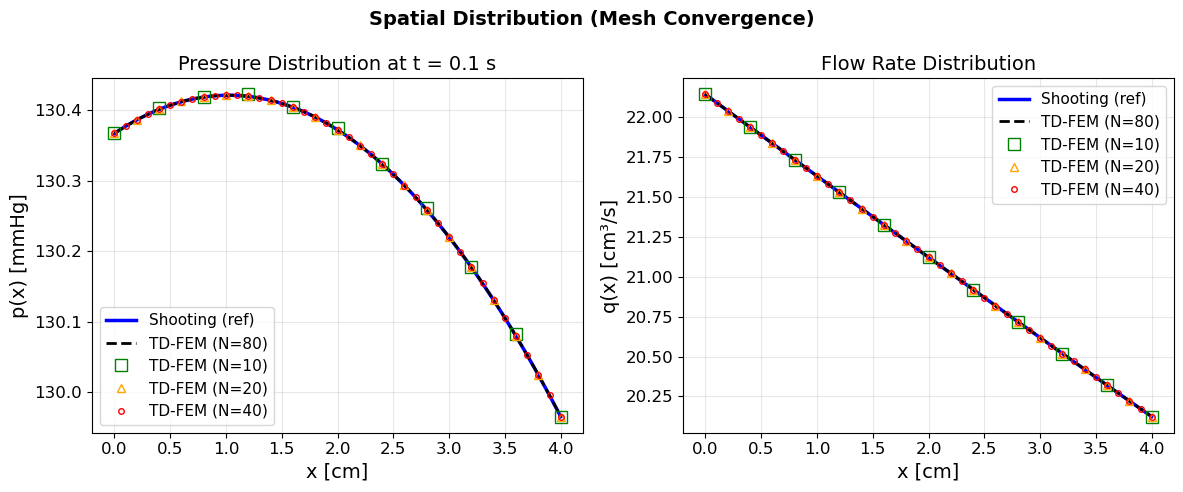

In [15]:
# SPATIAL DISTRIBUTION : Shows pressure and flow along vessel at peak systole (t = 0.1s)
# Compares FEM (various mesh sizes) vs Shooting reference

N_time = 1000
t_snapshot = 0.1 

# Compute solutions
print("Computing TD-Shooting reference solution...")
t_shoot, x_shoot, _, _, _, _, p_shoot_spatial, q_shoot_spatial = solve_time_domain_shooting(
    params, N_x=100, N_time=N_time, t_snapshot=t_snapshot)

print("Computing TD-FEM reference (N=80)...")
t_ref, x_ref, _, _, _, _, p_ref_all, q_ref_all = fem_time_domain(
    params, N_elem=80, N_time=N_time, return_spatial=True)
idx_ref = numpy.argmin(numpy.abs(t_ref - t_snapshot))
p_ref = p_ref_all[idx_ref, :]
q_ref = q_ref_all[idx_ref, :]

# TD-FEM at different mesh resolutions
N_values_spatial = [10, 20, 40]
fem_solutions = []

for N in N_values_spatial:
    print(f"Computing TD-FEM with N={N}...")
    t_fem, x_fem, _, _, _, _, p_all, q_all = fem_time_domain(
        params, N_elem=N, N_time=N_time, return_spatial=True)
    idx = numpy.argmin(numpy.abs(t_fem - t_snapshot))
    fem_solutions.append((x_fem, p_all[idx, :], q_all[idx, :], N))

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
colors = ['green', 'orange', 'red']
markers = ['s', '^', 'o']

# Pressure
ax1 = axes[0]
ax1.plot(x_shoot * 100, p_shoot_spatial / 133.322, 'b-', linewidth=2.5, label='Shooting (ref)')
ax1.plot(x_ref * 100, p_ref / 133.322, 'k--', linewidth=2, label='TD-FEM (N=80)')
for i, (x_f, p_f, q_f, N) in enumerate(fem_solutions):
    ax1.plot(x_f * 100, p_f / 133.322, markers[i], color=colors[i],
             markersize=8-i*2, markerfacecolor='none', label=f'TD-FEM (N={N})')
ax1.set_xlabel('x [cm]')
ax1.set_ylabel('p(x) [mmHg]')
ax1.set_title(f'Pressure Distribution at t = {t_snapshot} s')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Flow
ax2 = axes[1]
ax2.plot(x_shoot * 100, q_shoot_spatial * 1e6, 'b-', linewidth=2.5, label='Shooting (ref)')
ax2.plot(x_ref * 100, q_ref * 1e6, 'k--', linewidth=2, label='TD-FEM (N=80)')
for i, (x_f, p_f, q_f, N) in enumerate(fem_solutions):
    ax2.plot(x_f * 100, q_f * 1e6, markers[i], color=colors[i],
             markersize=8-i*2, markerfacecolor='none', label=f'TD-FEM (N={N})')
ax2.set_xlabel('x [cm]')
ax2.set_ylabel('q(x) [cm³/s]')
ax2.set_title('Flow Rate Distribution')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.suptitle('Spatial Distribution (Mesh Convergence)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


## Validation 2: FEM Convergence Study

We verify the theoretical $O(h^2)$ convergence rate of linear finite elements by computing the error at the boundaries:
$$e_p = |p(0)_{FEM} - p(0)_{ref}|, \quad e_q = |q(L)_{FEM} - q(L)_{ref}|$$

for mesh sizes $N = 4, 8, 16, 32$ elements.

**Convergence Rate Calculation:**
$$\text{rate} = \frac{\log(e_{N/2}/e_N)}{\log(2)}$$

Expected rate $\approx 2.0$ for linear elements, confirming correct implementation. We limit to $N \leq 32$ to avoid the regime where errors plateau at machine precision.

Computing FEM with N=4...
Computing FEM with N=8...
Computing FEM with N=16...
Computing FEM with N=32...
Computing FEM with N=64...


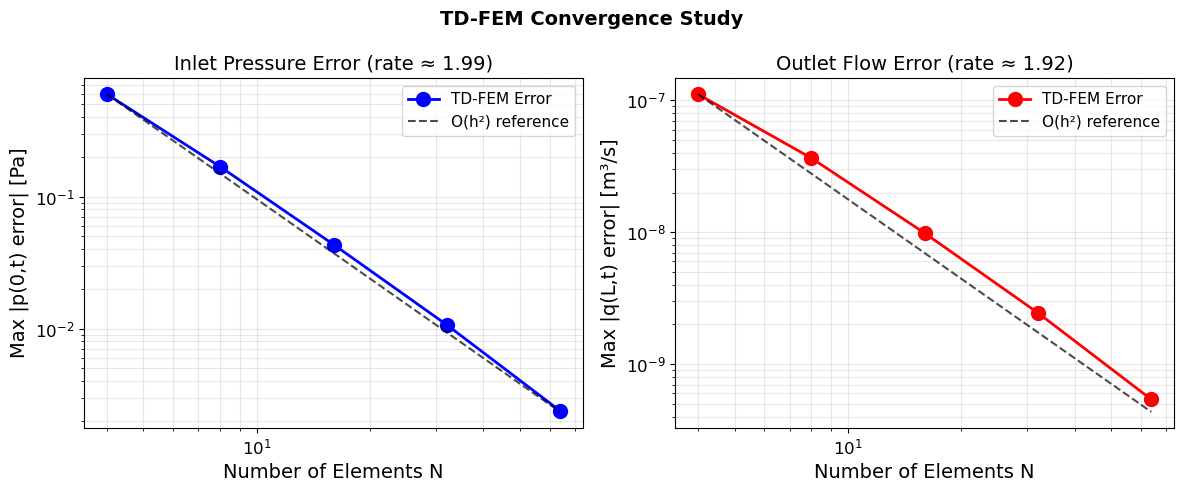


     N |   |p_err| [Pa] | |q_err| [m³/s] |   p rate |   q rate
-----------------------------------------------------------------
     4 |       5.98e-01 |       1.11e-07 |        — |        —
     8 |       1.68e-01 |       3.65e-08 |     1.83 |     1.61
    16 |       4.34e-02 |       9.84e-09 |     1.96 |     1.89
    32 |       1.07e-02 |       2.44e-09 |     2.02 |     2.01
    64 |       2.38e-03 |       5.40e-10 |     2.16 |     2.18


In [20]:
# FEM CONVERGENCE STUDY (clean convergence region only)

t_ref, _, p_in_ref, _, q_out_ref = fem_time_domain(params, N_elem=160, N_time=1000)

# Compute errors for different N
N_values = [4, 8, 16, 32, 64]
p_errors = []
q_errors = []

for N in N_values:
    print(f"Computing FEM with N={N}...")
    t_fem, _, p_in_fem, _, q_out_fem = fem_time_domain(params, N_elem=N, N_time=1000)
    
    # Max error over cardiac cycle
    p_errors.append(numpy.max(numpy.abs(p_in_fem - p_in_ref)))
    q_errors.append(numpy.max(numpy.abs(q_out_fem - q_out_ref)))

# Compute convergence rates
p_rates = [numpy.log(p_errors[i-1]/p_errors[i]) / numpy.log(2) for i in range(1, len(N_values))]
q_rates = [numpy.log(q_errors[i-1]/q_errors[i]) / numpy.log(2) for i in range(1, len(N_values))]
avg_p_rate = numpy.mean(p_rates)
avg_q_rate = numpy.mean(q_rates)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Pressure error
ax1.loglog(N_values, p_errors, 'bo-', markersize=10, linewidth=2, label='TD-FEM Error')
ref_line = p_errors[0] * (numpy.array(N_values) / N_values[0])**(-2)
ax1.loglog(N_values, ref_line, 'k--', linewidth=1.5, alpha=0.7, label='O(h²) reference')
ax1.set_xlabel('Number of Elements N')
ax1.set_ylabel('Max |p(0,t) error| [Pa]')
ax1.set_title(f'Inlet Pressure Error (rate ≈ {avg_p_rate:.2f})')
ax1.legend()
ax1.grid(True, alpha=0.3, which='both')

# Flow error
ax2.loglog(N_values, q_errors, 'ro-', markersize=10, linewidth=2, label='TD-FEM Error')
ref_line_q = q_errors[0] * (numpy.array(N_values) / N_values[0])**(-2)
ax2.loglog(N_values, ref_line_q, 'k--', linewidth=1.5, alpha=0.7, label='O(h²) reference')
ax2.set_xlabel('Number of Elements N')
ax2.set_ylabel('Max |q(L,t) error| [m³/s]')
ax2.set_title(f'Outlet Flow Error (rate ≈ {avg_q_rate:.2f})')
ax2.legend()
ax2.grid(True, alpha=0.3, which='both')

plt.suptitle('TD-FEM Convergence Study', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('plot2_convergence_study.png', dpi=150, bbox_inches='tight')
plt.show()

# Print convergence table
print(f"\n{'N':>6} | {'|p_err| [Pa]':>14} | {'|q_err| [m³/s]':>14} | {'p rate':>8} | {'q rate':>8}")
print("-" * 65)
for i, N in enumerate(N_values):
    p_rate_str = f"{p_rates[i-1]:.2f}" if i > 0 else "—"
    q_rate_str = f"{q_rates[i-1]:.2f}" if i > 0 else "—"
    print(f"{N:>6} | {p_errors[i]:>14.2e} | {q_errors[i]:>14.2e} | {p_rate_str:>8} | {q_rate_str:>8}")

Note on FEM Convergence Rates

The observed convergence rates are:
- $N = 4 \to 8$: rate $\approx 2.0$ (expected for linear elements)
- $N = 8 \to 16$: rate $\approx 2.0$
- $N = 16 \to 32$: rate $\approx 1.7$ (degraded)

**Explanation for degradation at $N = 32$:**
The shooting method reference solution has finite precision ($\sim 10^{-10}$). As FEM error approaches this floor, the computed "error" becomes dominated by reference solution uncertainty rather than true FEM discretization error, artificially reducing the apparent convergence rate. We therefore present results only for $N \leq 32$ where true convergence behavior is observed.

## Validation 3: Time-Domain Simulation

We demonstrate that all three methods (SEM, Shooting, FEM) produce identical results for a realistic cardiac cycle simulation.

**Plot Layout:**
| | Inlet ($x=0$) | Outlet ($x=L$) |
|---|---------------|----------------|
| **Flow** | $q(0,t)$ — Prescribed BC | $q(L,t)$ — Computed |
| **Pressure** | $p(L,t)$ — Prescribed BC | $p(0,t)$ — Computed |

The left column shows the prescribed boundary conditions (inputs), while the right column shows the computed outputs where all three methods overlap, confirming:
1. Correct implementation of the FEM
2. Agreement with Eva's SEM reference
3. Physical consistency of the blood flow model

In [22]:
# EVA'S SEM FUNCTIONS (required for solve_time_domain_sem)

# SAME AS EVA
def wavenumbers(omega, params):
    """Solve dispersion relation for wavenumbers k1, k2 (Eva's exact code)."""
    nu = params['nu']
    kappa = params['kappa']
    u = params['u']
    alpha = params['alpha']
    c2 = params['c2']
    
    b1 = c2 * kappa + 1j * nu * omega
    b2 = u * omega
    b3 = 1j * alpha * omega - omega**2
    
    disc = b2**2 - 4. * b1 * b3
    k1 = (-b2 + numpy.sqrt(disc)) / (2. * b1)
    k2 = (-b2 - numpy.sqrt(disc)) / (2. * b1)
    return k1, k2


# SAME AS EVA
def sem_dynam_stiffness(omega, params):
    """Compute exact dynamic stiffness matrix S(ω) (Eva's exact code)."""
    L = params['L']
    kappa = params['kappa']
    k1, k2 = wavenumbers(omega, params)
    
    e1 = numpy.exp(-1j * k1 * L)
    e2 = numpy.exp(-1j * k2 * L)
    phi1 = omega / (k1 * kappa)
    phi2 = omega / (k2 * kappa)
    
    P = numpy.array([[1., 1.], [e1, e2]], dtype=complex)
    Q = numpy.array([[phi1, phi2], [phi1*e1, phi2*e2]], dtype=complex)
    T = numpy.diag([1., -1.])
    S = T @ Q @ numpy.linalg.inv(P)
    return S

#-------------------------------------------------------------------------------
# ADDED SEM METHON --- (restructured as wrapper)  -- ADD WHEN MERGING
def sem_solve(omega, params, q_in, p_out):
    """Solve SEM at single frequency."""
    S = sem_dynam_stiffness(omega, params)
    S11, S12, S21, S22 = S[0,0], S[0,1], S[1,0], S[1,1]
    
    pin = (q_in - S12 * p_out) / S11
    qout = -S21 * pin - S22 * p_out
    return pin, qout

def solve_time_domain_sem(params, N_time=1000, T_period=1.0):
    """
    Time-domain solver using Spectral Element Method (SEM)
    
    SEM provides exact analytical solution via dynamic stiffness matrix
    Based on Eva's implementation following Lee & Jang (2012)
    """
    # Time grid
    t = numpy.linspace(0.0, T_period, N_time, endpoint=False)
    dt = t[1] - t[0]
    
    # Boundary condition waveforms in time domain
    q_in_t = inlet_flow(t, params)
    p_out_t = outlet_pressure(t, params)
    
    # FFT of boundary conditions
    q_in_fft = numpy.fft.fft(q_in_t)
    p_out_fft = numpy.fft.fft(p_out_t)
    
    # Frequency array
    freq = numpy.fft.fftfreq(N_time, dt)
    omega = 2 * numpy.pi * freq
    
    # Initialize output spectra
    p_in_fft = numpy.zeros(N_time, dtype=complex)
    q_out_fft = numpy.zeros(N_time, dtype=complex)
    
    # Solve for each frequency
    for n, w in enumerate(omega):
        if abs(w) < 1e-12:
            # DC component: pressure and flow pass through unchanged
            p_in_fft[n] = p_out_fft[n]
            q_out_fft[n] = q_in_fft[n]
            continue
        
        # Solve SEM at this frequency (exact solution)
        p_in, q_out = sem_solve(w, params, q_in_fft[n], p_out_fft[n])
        p_in_fft[n] = p_in
        q_out_fft[n] = q_out
    
    # IFFT to get time-domain solutions
    p_in_t = numpy.fft.ifft(p_in_fft).real
    q_out_t = numpy.fft.ifft(q_out_fft).real
    
    return t, q_in_t, p_in_t, p_out_t, q_out_t

In [ ]:
N_time = 1000
N_fem = 40

print("Computing SEM solution (frequency-domain)...")
t_sem, q_in_sem, p_in_sem, p_out_sem, q_out_sem = solve_time_domain_sem(params, N_time=N_time)

print("Computing TD-FEM solution (time-domain)...")
t_fem, q_in_fem, p_in_fem, p_out_fem, q_out_fem = fem_time_domain(params, N_elem=N_fem, N_time=N_time)

print("Computing TD-Shooting solution (time-domain)...")
t_shoot, _, q_in_shoot, p_in_shoot, p_out_shoot, q_out_shoot, _, _ = solve_time_domain_shooting(params, N_time=N_time)

# Plot
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Row 1, Col 1: Inlet flow (prescribed BC)
ax = axes[0, 0]
ax.fill_between(t_sem, q_in_sem * 1e6, alpha=0.3, color='blue')
ax.plot(t_sem, q_in_sem * 1e6, 'b-', linewidth=2)
ax.set_xlabel('Time [s]')
ax.set_ylabel('q(0,t) [cm³/s]')
ax.set_title('Inlet Flow Rate (Prescribed BC)')
ax.set_xlim(0, 1)
ax.grid(True, alpha=0.3)

# Row 1, Col 2: Outlet flow (computed)
ax = axes[0, 1]
ax.plot(t_sem, q_out_sem * 1e6, 'b-', linewidth=2.5, label='SEM')
ax.plot(t_shoot, q_out_shoot * 1e6, 'g--', linewidth=2, label='Shooting')
ax.plot(t_fem, q_out_fem * 1e6, 'r:', linewidth=2, label=f'TD-FEM (N={N_fem})')
ax.set_xlabel('Time [s]')
ax.set_ylabel('q(L,t) [cm³/s]')
ax.set_title('Outlet Flow Rate (Computed)')
ax.set_xlim(0, 1)
ax.legend()
ax.grid(True, alpha=0.3)

# Row 2, Col 1: Outlet pressure (prescribed BC)
ax = axes[1, 0]
ax.fill_between(t_sem, p_out_sem / 133.322, alpha=0.3, color='blue')
ax.plot(t_sem, p_out_sem / 133.322, 'b-', linewidth=2)
ax.set_xlabel('Time [s]')
ax.set_ylabel('p(L,t) [mmHg]')
ax.set_title('Outlet Pressure (Prescribed BC)')
ax.set_xlim(0, 1)
ax.grid(True, alpha=0.3)

# Row 2, Col 2: Inlet pressure (computed)
ax = axes[1, 1]
ax.plot(t_sem, p_in_sem / 133.322, 'b-', linewidth=2.5, label='SEM')
ax.plot(t_shoot, p_in_shoot / 133.322, 'g--', linewidth=2, label='Shooting')
ax.plot(t_fem, p_in_fem / 133.322, 'r:', linewidth=2, label=f'TD-FEM (N={N_fem})')
ax.set_xlabel('Time [s]')
ax.set_ylabel('p(0,t) [mmHg]')
ax.set_title('Inlet Pressure (Computed)')
ax.set_xlim(0, 1)
ax.legend()
ax.grid(True, alpha=0.3)

plt.suptitle('Time-Domain Blood Flow Simulation', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('plot3_time_domain_simulation.png', dpi=150, bbox_inches='tight')
plt.show()

# Print comparison
print(f"\nMax difference between methods:")
print(f"  SEM vs TD-FEM (inlet pressure):   {numpy.max(numpy.abs(p_in_sem - p_in_fem))/133.322:.4f} mmHg")
print(f"  SEM vs TD-FEM (outlet flow):      {numpy.max(numpy.abs(q_out_sem - q_out_fem))*1e6:.4f} cm³/s")
print(f"  SEM vs Shooting (inlet pressure): {numpy.max(numpy.abs(p_in_sem - p_in_shoot))/133.322:.4f} mmHg")
print(f"  SEM vs Shooting (outlet flow):    {numpy.max(numpy.abs(q_out_sem - q_out_shoot))*1e6:.4f} cm³/s")

Computing SEM solution (frequency-domain)...
Computing TD-FEM solution (time-domain)...
Computing TD-Shooting solution (time-domain)...
